In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam
import re

In [9]:
bamfile = pysam.AlignmentFile("/qbio/shjo/23-1_bioinformatics/expansion/aligned/2J3.MD.filtered.bam", "rb")
for read in bamfile.fetch(until_eof=True):
    print(read.cigarstring)
    print(read.cigartuples)
    break
# cigartuples: M:0, I:1, D:2, N:3, S:4, H:5, P:6, =:7, X:8, B:9

22M2S
[(0, 22), (4, 2)]


In [10]:
bamfile = pysam.AlignmentFile("/qbio/shjo/23-1_bioinformatics/expansion/aligned/2J3.MD.filtered.bam", "rb")
for read in bamfile.fetch(until_eof=True):
    print(read.reference_start)
    print(read.get_aligned_pairs())
    break

3119063
[(0, 3119063), (1, 3119064), (2, 3119065), (3, 3119066), (4, 3119067), (5, 3119068), (6, 3119069), (7, 3119070), (8, 3119071), (9, 3119072), (10, 3119073), (11, 3119074), (12, 3119075), (13, 3119076), (14, 3119077), (15, 3119078), (16, 3119079), (17, 3119080), (18, 3119081), (19, 3119082), (20, 3119083), (21, 3119084), (22, None), (23, None)]


In [7]:
bamfile = pysam.AlignmentFile("/qbio/shjo/23-1_bioinformatics/expansion/aligned/2J3.MD.filtered.bam", "rb")
for read in bamfile.fetch(until_eof=True):
    if read.has_tag("MD") and re.search(r'[ATGC]', read.get_tag("MD")): 
        print(read.get_reference_sequence())
        print(read.query_sequence)
        print(read.cigarstring)
        print(read.get_tag("MD"))
    else: pass
    break

AAATTGTGGGAGTGGTgCCtGG
AAATTGTGGGAGTGGTACCAGGAA
22M2S
16G2T2


In [39]:
from tqdm import tqdm

# + strand만으로 진행
def get_bin(L, pos):
    return pos//(L/20)

# initialize error_count dict
error_count = {bin_number: {'I':0,'D':0,'Sub':0,'M':0} for bin_number in range(20)}


bamfile = pysam.AlignmentFile("/qbio/shjo/23-1_bioinformatics/expansion/aligned/2J3.MD.filtered.bam", "rb")
for read in tqdm(bamfile.fetch(until_eof=True)):
    
    reference_seq = read.get_reference_sequence()
    pos_list = read.get_aligned_pairs()
    reference_start = read.reference_start
    
    S_num = 0   # soft clipping된 갯수 (soft clipping된 부분은 get_reference_sequence에 안 들어감)
    for op, length in read.cigartuples:
        if op == 4: S_num += length
        else: pass
      
    index = 0   # index: index for pos_list
    for op, length in read.cigartuples: 
        if op == 0:  # M   # which contains both match and mismatch(substitution) 
            for i in range(index, length+index):
                read_pos, reference_pos = pos_list[i]
                if type(reference_pos) == type(None) or type(read_pos) == type(None): continue
                if reference_seq[reference_pos-reference_start] != read.query_sequence[read_pos]:
                    error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['Sub'] += 1
                else: 
                    error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['M'] += 1
            index += length   

        elif op == 1:  # I  # insertion
            read_pos, reference_pos = pos_list[index-1]  # insertion의 왼쪽에서 error가 일어났다고 가정
            if type(reference_pos) == type(None) or type(read_pos) == type(None): continue
            error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['I'] += length 
            index += length

        elif op == 2: # D  # deletion    
            for i in range(index, length+index):
                _, reference_pos = pos_list[i]
                if type(reference_pos) == type(None): continue
                error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['D'] += 1
            index += length

        elif op == 4: # S  # soft clipping
            index += length    

        else: pass  
bamfile.close()

error_df = pd.DataFrame(error_count).T
error_df

11603772it [12:27, 15518.04it/s]

496583372


,I,D,Sub,M
0,0,0,48083,29815474
1,0,4,252333,23877796
2,137,2210,269838,24738376
3,260,13936,258075,23687580
4,2540,41376,283750,25002374
5,2031,73383,239437,23424856
6,2294,211097,262189,24538817
7,7989,164812,582560,22295805
8,2376,265392,598855,23914296
9,3443,160689,302802,22189214


In [52]:
error_df['pI'] = (error_df['I']/error_df.sum(axis=1))*100  # row별 총합
error_df['pD'] = (error_df['D']/error_df.sum(axis=1))*100
error_df['pSub'] = (error_df['Sub']/error_df.sum(axis=1))*100
error_df['pM'] = (error_df['M']/error_df.sum(axis=1))*100
error_df

,I,D,Sub,M,pI,pD,pSub,pM
0,0,0,48083,29815474,0.000000,0.000000,0.161009,99.838987
1,0,4,252333,23877796,0.000000,0.000017,1.045717,98.954258
2,137,2210,269838,24738376,0.000548,0.008836,1.078896,98.911712
3,260,13936,258075,23687580,0.001085,0.058164,1.077114,98.863628
4,2540,41376,283750,25002374,0.010028,0.163348,1.120211,98.706405
5,2031,73383,239437,23424856,0.008555,0.309115,1.008593,98.673727
6,2294,211097,262189,24538817,0.009171,0.843902,1.048152,98.098764
7,7989,164812,582560,22295805,0.034658,0.714983,2.527247,96.723094
8,2376,265392,598855,23914296,0.009588,1.070953,2.416597,96.502844
9,3443,160689,302802,22189214,0.015197,0.709251,1.336511,97.939028


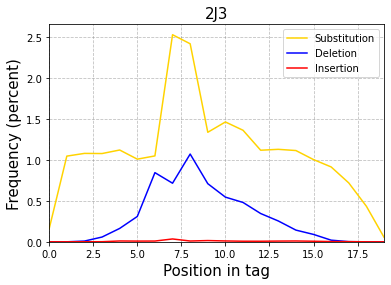

In [60]:
plt.plot(error_df['pSub'], label='Substitution', color='#FFD300')
plt.plot(error_df['pD'], label='Deletion', color='blue')
plt.plot(error_df['pI'], label='Insertion', color='red')

plt.title('2J3', fontsize=15)
plt.grid(linestyle='--', color='grey', alpha=0.5)
plt.xlim(0,19)
plt.ylim(0,)

plt.xlabel('Position in tag', fontsize=15)
plt.ylabel('Frequency (percent)', fontsize=15)

plt.legend()
plt.show()